In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [3]:
FORECAST = 5
EPS = 120
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
dset = SingleStop(SROUTE, 30, 'train', 32).generator()
evalset = SingleStop(SROUTE, 30, 'test', 32).generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.26s)
 [*] Has trainable inds: 3480
 [*] Subset train: 2808
Locals dataset: test
 [*] Loaded routes: 1 (0.25s)
 [*] Has trainable inds: 3480
 [*] Subset test: 672


In [5]:
from models.RNN import RNN

In [6]:
model = RNN(forecast=FORECAST, hidden_size=512, deep=False).to(device)
model.device = device

In [7]:
criterion, opt, sch = model.params(lr=0.001)

In [8]:
evaluate(evalset, model, criterion)

Eval loss: 19.9138669946364


In [9]:
losses = []
eval_losses = []
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    eval_losses.append(evaluate(evalset, model, criterion, result=True))
#     torch.save(model.state_dict(), 'checkpoints/%s_e%d.pth' % (model.name, eii+1))
    sys.stdout.flush()
    sch.step()

[1/120 : 88/88] - L2.82       
Eval loss: 7.653896717620747
[2/120 : 88/88] - L6.66       
Eval loss: 7.445197403963123
[3/120 : 88/88] - L2.54       
Eval loss: 7.2639068726982385
[4/120 : 88/88] - L90.48      
Eval loss: 7.09068362175354
[5/120 : 88/88] - L3.61       
Eval loss: 6.931950083534632
[6/120 : 88/88] - L2.35       
Eval loss: 6.778767303696701
[7/120 : 88/88] - L5.23       
Eval loss: 6.645325103774667
[8/120 : 88/88] - L7.98       
Eval loss: 6.53463425992855
[9/120 : 88/88] - L9.20       
Eval loss: 6.439763788932136
[10/120 : 88/88] - L2.41       
Eval loss: 6.369287211714046
[11/120 : 88/88] - L2.10       
Eval loss: 6.319094628095627
[12/120 : 88/88] - L1.86       
Eval loss: 6.281580648518035
[13/120 : 88/88] - L1.82       
Eval loss: 6.232367209291884
[14/120 : 88/88] - L2.03       
Eval loss: 6.188906343387706
[15/120 : 88/88] - L2.06       
Eval loss: 6.154270489301
[16/120 : 88/88] - L8.35       
Eval loss: 6.124352393937962
[17/120 : 88/88] - L1.82       
Eval 

Process Process-1251:
Process Process-1249:
Process Process-1250:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Process Process-1252:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/torch/utils/data/dataloader.py", line 96, in _worker_loop
    r = index_queue.get(timeout=MANAGER_STATUS_CHECK_INTERVAL)
Process Process-1253:
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Process Process-1254:
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 10

KeyboardInterrupt: 

In [14]:
torch.save(model.state_dict(), 'checkpoints/%s.pth' % (model.name))

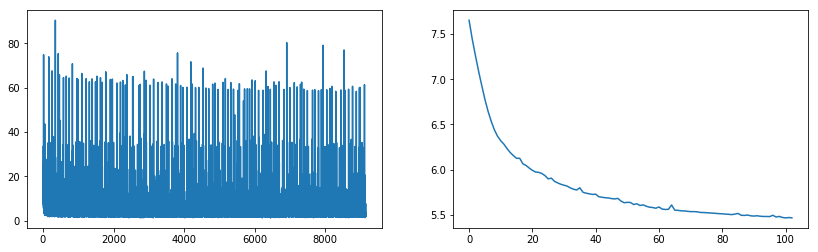

In [10]:
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.subplot(1, 2, 2)
plt.plot(eval_losses)
plt.show();plt.close()

6


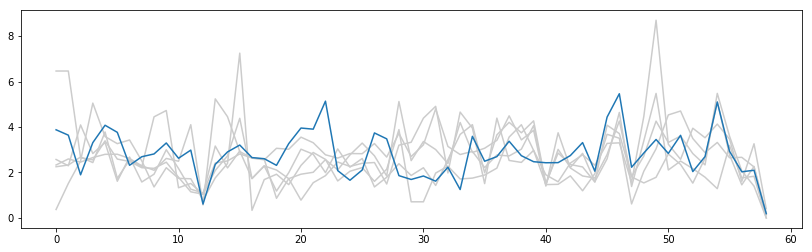

In [11]:
data = history_byname(SROUTE)

sample = data[int(TSTEPS*0.8):]
inds, integs = high_integ(sample[6:])
inds += 6
print(inds[0])
sample = sample[inds[0]-6:inds[0]]
# sample = hist_smooth(sample)
show_context(sample)

In [12]:
preds = []
for bi in range(10, sample.shape[1]+1):
    hist = sample[:, bi-10:bi].T
    Xs = np.expand_dims(hist, 1)
    Xs = torch.from_numpy(Xs).to(device).float()
    seqs = list(map(lambda vec: vec.squeeze(0), torch.split(Xs, 1)))
    seqs = list(reversed(seqs))

    yout = model(seqs)
    preds.append(tonpy(yout))

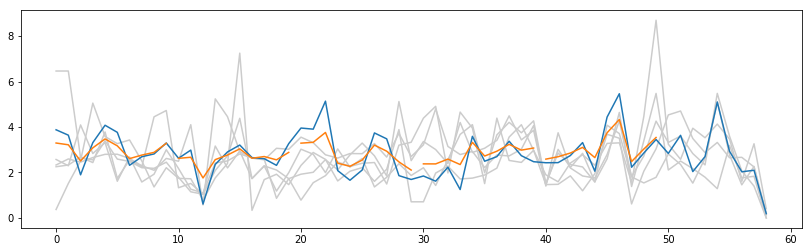

In [13]:
show_context(sample, draw=False)
for bi in range(10, sample.shape[1]+1, 10):
    ylast = np.flip(preds[bi-10][:, 0, -1])
    xpos = list(range(bi-10, bi))
    plt.plot(xpos, ylast, color='C1')
plt.show(); plt.close()

In [15]:
from scipy.ndimage import gaussian_filter as blur

In [25]:
smooth = np.array([blur(row, 2) for row in sample])

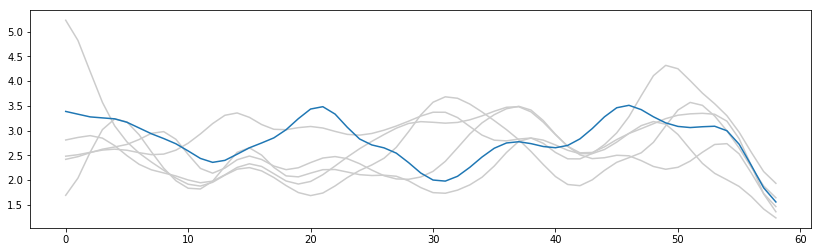

In [26]:
show_context(smooth)